# Machine Learning with Adversaries: Byzantine Tolerant Gradient Descent

### Ziad El Assal, Oscar Courbit

This project revolves around Blanchard, El Mhamdi, Guerraoui & Steiner' founding [paper](https://papers.nips.cc/paper/2017/hash/f4b9ec30ad9f68f89b29639786cb62ef-Abstract.html), **Machine Learning with Advesaries: Byzantine Tolerant Gradient Descent** (2017). The first part, which is not treated in this notebook, consists in a thourough analysis of the article. In the second part—which is the subject of this notebook—we design and implementat a follow-up of the paper, based on Byzantine workers suspension. 

Both parts have been presented to Prof. El Mahdi El Mhamdi, co-author during an oral defence. 


## Context

Blanchard et al.'s article study the resilience to Byzantine failures of distributed implementations of stochastic gradient descent (SGD). The article first defines a criterion to quantify the resilience of an algorithm to Byzantine workers, the ($\alpha$-$f$)-Byzantine resilience, then introduces an aggregation function, named Krum, that has strong resilience properties.

Due to the increasing computational resources needed to train machine learning models, most industry-level machine learning implementations are now distributed, meaning that they rely on several *workers* to update a single model. We focus on a specific step in the training: updating the model parameters by minimizing the loss, using SGD. 

In practice, every worker is provided with a part of the dataset. It returns a vector, which is its estimated gradient of the loss function, to a central server. The server *aggregates* these gradients using an *aggregation rule*, to compute a more precise estimate of the real gradient. A Byzantine worker (from the Byzantine generals problem) is a worker that *can* behave badly, either because it is broken or corrupted.

The choice of the *aggregation rule* is critical. The mean, for instance, is not resilient to the presence of a single Byzantine worker.

Krum, which is explaned in detail in the paper, is an aggregation rule that satisfies the resilience property. It is the first provably Byzantine-resilient algorithm for distributed SGD.

## Follow-up idea

We are faced with the classic Byzantine problem. Among $n$ workers, $n-f$ of them are Byzantine and they remain the same during the whole experiment. This is opposed to the *generalized Byzantine problem*, where there are exactly $n-f$ Byzantine workers at each step, but not necessarily the same. We exploit this specificity by introducting workers suspension. **The idea is to identify suspected Byzantine workers according to the vector they return, and suspend these suspects during a certain period, in the hope they are Byzantine.**

This is done following the steps below:
1. All the vectors $V_i$ returned by worker $i$ are sorted by their score $s(i)$. The score is introduced in the article and is defined as $s(i) = \sum_{i\rightarrow j} \|V_i − V_j\|^2$ where the sum runs over the $n − f − 2$ closest vectors to $V_i$. 
2. The $n_s$ worst ranked workers are suspended during a period $t_s$, where $n_s$ and $t_s$ are predefined parameters.
3. At the following step, *all* the vectors are examined for possible suspension. But the aggregation rule only takes into account the vectors of the non-suspended workers.


## Implementation

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

### Function to optimize

We will test our aggregation rule on the following function (borrowed from Lijia Yu)
$$f:(x,y) \mapsto \sin(\frac{1}{2} x^2 - \frac{1}{4} y^2 + 3) \cos(2x + 1 - \exp(y)),$$
which is difficult to optimize because of the presence of multiple local minima.

In [3]:
# http://yulijia.net/vistat/2013/03/gradient-descent-algorithm-with-r
def f1(X):
    x, y = X[0], X[1]
    return np.sin(x**2/2 - y**4/4 + 3)*np.cos(2*x + 1 - np.exp(y))

def df1(X):
    x, y = X[0], X[1]
    dx = ( x*np.cos(x**2/2 - y**4/4 + 3)*np.cos(2*x + 1 - np.exp(y)) 
        - 2*np.sin(x**2/2 - y**4/4 + 3)*np.sin(2*x + 1 - np.exp(y)))
    
    dy = ( -y**3*np.cos(x**2/2 - y**4/4 + 3)*np.cos(2*x + 1 - np.exp(y))
     + np.exp(y)*np.sin(x**2/2 - y**4/4 + 3)*np.sin(2*x + 1 - np.exp(y)))
    
    return np.array([dx,dy])


#https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
def eggholder(x):
     return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
             -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))


In [4]:
def norm2(X):
    return X[0]**2 + X[1]**2

def dnorm2(X):
    return np.array([2*X[0], 2*X[1]])

### Aggregation rules

We define a base gradient aggregation rule class `GAR`, then several specific classes that inherit from `GAR`.

In [5]:
class GAR:
    """ Base gradient aggregation rule class.
    """

    def __init__(self, nbworkers, nbbyzwrks):
        """ Unimplemented constructor.

        Args:
          nbworkers: Total number of workers
          nbbyzwrks: Declared number of Byzantine workers
        """
        raise NotImplementedError

    def aggregate(self, gradients):
        """ Build the gradient aggregation operation of the given gradients.

        Args:
          gradients: Computed gradient tensors

        Returns:
          Aggregated gradient tensor
        """
        raise NotImplementedError


In [6]:
class Median(GAR):
    """
    Median aggregator class
    """
    
    def __init__(self, nbworkers, nbbyzwrks):
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = None
        self.suspension_time = None
        self.probability = None
        
    def aggregate(self, gradients):
        gradient = np.zeros(len(gradients[0]))
        for i in range(len(gradient)):
            grads_i = [gradients[j][i] for j in range(len(gradients))]
            med_i = np.median(grads_i)
            gradient[i] = med_i
        return gradient, None

In [7]:
class Average(GAR):
    """
    Average aggregator class
    """
    def __init__(self, nbworkers, nbbyzwrks):
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = None
        self.suspension_time = None
        self.probability = None
        
    def aggregate(self, gradients):
        
        return np.mean(gradients, axis=0), None

In [8]:
class AverageSuspend(GAR):
    """
    Average aggregator class with suspension
    """
    def __init__(self, nbworkers, nbbyzwrks, nb_suspended=None, suspension_time=None, probability=None):
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = nb_suspended
        self.suspension_time = suspension_time
        self.probability = probability
        
    def aggregate(self, gradients):
        """Aggregates the gradients, taking in consideration the active workers only.
        
        Args:
            gradients: List of submitted gradients, as numpy arrays
            active_workers: List of (boolean, int) of length nbworkers

        Output:
            gradient: aggregated gradient
            triplets: list of (gradient, score, worker_id) sorted by score
        """
        if self.nbselected == self.nbworkers:
            # Fast path average
            result = gradients[0]
            for i in range(1, self.nbworkers):
                result += gradients[i]
                result /= float(self.nbworkers)
            return result, None
        
        else:
            
            scores = [list() for i in range(self.nbworkers)]
            
            # Calculate distances
            for i in range(self.nbworkers - 1):
                score = scores[i]
                for j in range(i + 1, self.nbworkers):
                    # With: 0 <= i < j < nbworkers
                    distance = np.linalg.norm(gradients[i] - gradients[j])
                    if math.isnan(distance):
                        distance = math.inf
                    score.append(distance)
                    scores[j].append(distance)
            
            # Calculate scores
            nbinscore = self.nbworkers - self.nbbyzwrks - 2
            for i in range(self.nbworkers):
                score = scores[i]
                score.sort()
                scores[i] = sum(score[:nbinscore])
                
            # Return the average of the m gradients with the smallest score
            triplets = [(gradients[i], scores[i], i) for i in range(self.nbworkers)]
            triplets.sort(key=lambda triplet : triplet[1]) #triplets sorted by score
            
            result = np.zeros(len(gradients[0]))
            
            nbadded = 0#number of gradients to average
            for i in range(self.nbworkers):
                worker_id = triplets[i][2]
                if self.workers_status[worker_id][0]:    #if the worker is active, add the gradient
                    result += triplets[i][0]             
                    nbadded +=1
            result = result/float(nbadded)
            
            return result, triplets
        
    def update_workers_status(self, sorted_workers_ids): 
        """
        Updates workers status inplace (active vs. suspended). 

        Args:
            active_workers (list of (boolean, int)) : int=suspension time left
            sorted_workers_ids (list of ids, sorted by score). Ex for [3,0,1,2]: 1 and 2 have the highest scores
            nb_suspended (int)                    
            suspension_time (int)

        Returns:
            
            """

        if self.nb_suspended is None or self.nb_suspended == 0:
            return 

        else:
            if self.suspension_time is None:
                print('suspension_time must be a positive integer if nb_suspended is not None.')
                return

            else:
                #update suspension time left 
                #print('Updating suspension time left...')
                for i in range(self.nbworkers):
                
                    if not self.workers_status[i][0]: #if the worker is currently suspended
                        #print(i, ' currently suspended')
                        if self.workers_status[i][1] <= 1: #if the worker has 1 step left to be suspended
                            self.workers_status[i][0], self.workers_status[i][1] = True, 0 #the worker is not suspended anymore
                        else:
                            
                            self.workers_status[i][1] -= 1
                        #print(self.workers_status)
                
                #suspend the nb_suspended workers with the highest scores    
                #print('Suspending the workers with the highest scores...')
                for i in range(self.nb_suspended):
                    rank = self.nbworkers-i-1
                    worker_id = sorted_workers_ids[rank] #the worker to suspend. 
                                                         #The first to suspend is the last the sorted list
                    #self.workers_status[worker_id] = self.suspend(self.workers_status[worker_id], rank)
                    #print('worker_id: ', worker_id)
                    
                    self.workers_status[worker_id] = [False, self.suspension_time]
                    
                    #with probability:
                    self._suspend(self.workers_status[worker_id], rank)
                    
                    #print(self.workers_status)
                    
    def _suspend(self, single_worker_status, rank):
        '''
        Suspends a worker with a certain probability

        Args:
            single_worker_status ([bool,int])
            rank (int) : rank of the worker in the list sorted by score
        Returns:
            updated_status 
        '''
        probabilities = [None, 'inv', 'log']

        if self.probability not in probabilities:
            raise NameError("probability must be in [None, 'inv', 'log']")

        else:
            if self.probability == None:
                return [False, self.suspension_time]
            
            elif self.probability == 'inv':
                if np.random.binomial(1,1/(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
            
            elif self.probability == 'log':
                if np.random.binomial(1,1/np.log(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
        
    

In [9]:
class Krum(GAR):
    '''
    Multi-Krum aggregator class
    '''
    
    def __init__(self, nbworkers, nbbyzwrks, nb_suspended=None, suspension_time=None, probability=None):
        
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.nbselected = nbworkers - nbbyzwrks - 2 #number of selected gradients. Equivalent to batch size
        self.workers_status = [[True,0] for i in range(nbworkers)]
        self.nb_suspended = nb_suspended
        self.suspension_time = suspension_time
        self.probability = probability
        
        
        
    def aggregate(self, gradients):
        """Aggregates the gradients, taking in consideration the active workers only.
        
        Args:
            gradients: List of submitted gradients, as numpy arrays
            active_workers: List of (boolean, int) of length nbworkers

        Output:
            gradient: aggregated gradient
            triplets: list of (gradient, score, worker_id) sorted by score
        """
        
        if self.nbselected == self.nbworkers:
            # Fast path average
            result = gradients[0]
            for i in range(1, self.nbworkers):
                result += gradients[i]
                result /= float(self.nbworkers)
            return result
        
        else:
            
            scores = [list() for i in range(self.nbworkers)]
            
            # Calculate distances
            for i in range(self.nbworkers - 1):
                score = scores[i]
                for j in range(i + 1, self.nbworkers):
                    # With: 0 <= i < j < nbworkers
                    distance = np.linalg.norm(gradients[i] - gradients[j])
                    if math.isnan(distance):
                        distance = math.inf
                    score.append(distance)
                    scores[j].append(distance)
            
            # Calculate scores
            nbinscore = self.nbworkers - self.nbbyzwrks - 2
            for i in range(self.nbworkers):
                score = scores[i]
                score.sort()
                scores[i] = sum(score[:nbinscore])
                
            # Return the average of the m gradients with the smallest score
            triplets = [(gradients[i], scores[i], i) for i in range(self.nbworkers)]
            triplets.sort(key=lambda triplet : triplet[1]) #triplets sorted by score
            
            result = np.zeros(len(gradients[0]))
            i, nbadded = 0, 0
            while nbadded <= self.nbselected and i < self.nbworkers:
                worker_id = triplets[i][2]
                if self.workers_status[worker_id][0]:    #if the worker is active
                    result += triplets[i][0]             #add the gradient
                    nbadded +=1
                i += 1
            result = result/float(nbadded)
            
            return result, triplets

    def update_workers_status(self, sorted_workers_ids): 
        """
        Updates workers status inplace. 

        Args:
            active_workers (list of (boolean, int)) : int=suspension time left
            sorted_workers_ids (list of ids, sorted by score). Ex for [3,0,1,2]: 1 and 2 have the highest scores
            nb_suspended (int)                    
            suspension_time (int)

        Returns:
            
            """

        if self.nb_suspended is None or self.nb_suspended == 0:
            return 

        else:
            if self.suspension_time is None:
                print('suspension_time must be a positive integer if nb_suspended is not None.')
                return

            else:
                #update suspension time left 
                #print('Updating suspension time left...')
                for i in range(self.nbworkers):
                
                    if not self.workers_status[i][0]: #if the worker is currently suspended
                        #print(i, ' currently suspended')
                        if self.workers_status[i][1] <= 1: #if the worker has 1 step left to be suspended
                            self.workers_status[i][0], self.workers_status[i][1] = True, 0 #the worker is not suspended anymore
                        else:
                            
                            self.workers_status[i][1] -= 1
                        #print(self.workers_status)
                
                #suspend the nb_suspended workers with the highest scores    
                #print('Suspending the workers with the highest scores...')
                for i in range(self.nb_suspended):
                    rank = self.nbworkers-i-1
                    worker_id = sorted_workers_ids[rank] #the worker to suspend. 
                                                         #The first to suspend is the last the sorted list
                    #self.workers_status[worker_id] = self.suspend(self.workers_status[worker_id], rank)
                    #print('worker_id: ', worker_id)
                    
                    self.workers_status[worker_id] = [False, self.suspension_time]
                    
                    #with probability:
                    self._suspend(self.workers_status[worker_id], rank)
                    
                    #print(self.workers_status)
                    
    def _suspend(self, single_worker_status, rank):
        '''
        Suspends a worker with a certain probability

        Args:
            single_worker_status ([bool,int])
            rank (int) : rank of the worker in the list sorted by score
        Returns:
            updated_status 
        '''
        probabilities = [None, 'inv', 'log']

        if self.probability not in probabilities:
            raise NameError("probability must be in [None, 'inv', 'log']")

        else:
            if self.probability == None:
                return [False, self.suspension_time]
            
            elif self.probability == 'inv':
                if np.random.binomial(1,1/(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
            
            elif self.probability == 'log':
                if np.random.binomial(1,1/np.log(self.nbworkers-rank+1)):
                    return [False, self.suspension_time]
                else:
                    return single_worker_status
        


### Workers class

In [10]:
class Workers():
    '''
    Workers class
    Note on the strategy:
        dict with keys 'name' and 'parameters'
    '''
    
    
    def __init__(self, nbworkers, nbbyzwrks, strategy):
        '''
        Args:
            nbworkers
            nbbyzwrks
            strategy (dict): the strategy adopted by byzantine workers
        '''
        
        self.nbworkers  = nbworkers
        self.nbbyzwrks  = nbbyzwrks
        self.strategy = strategy
        
    def compute_gradients(self, f, df, X):
        nbcrtwrks = self.nbworkers - self.nbbyzwrks #nb of correct workers
        gradients = list()
        correct_grad = df(X)
        
        noise = np.random.normal(0,.2,[nbcrtwrks, 2])
        
        #correct gradients
        for i in range(nbcrtwrks): 
            gradients.append(correct_grad + noise[i])
       
        #byzantine gradients
    
        if self.strategy['name'] == 'binom':
            p = strategy['params']
            
            for i in range(nbbyzwrks):
                binom = np.random.binomial(1,p)
                if binom:
                    #m = np.random.normal(0,3,2)
                    #byz_gradient =
                    byz_gradient = -2*correct_grad +  5*np.random.normal([.1,.1],2,2)
                else:
                    byz_gradient = correct_grad + np.random.normal(0,.1,2)
                gradients.append(byz_gradient)
            return gradients
        
        

### Optimizer class

In [11]:
class Optimizer():
    
    def __init__(self, aggregator, workers, lr=0.05, max_steps=100):
        self.aggregator = aggregator
        self.workers = workers
        self.lr = lr
        self.max_steps = max_steps
        
        
    def sgd_dim2(self, f, df):
        
        gradients_history, triplets_history, values = list(), list(), list()
        X = [.1,0]
        for idx in tqdm(range(max_steps)):
            
            #update the weights
            gradients = self.workers.compute_gradients(f, df, X)
            agg_gradient, triplets = self.aggregator.aggregate(gradients) #reminder: aggregate returns (result, triplets)
            X = X - lr*agg_gradient
            
            #save gradients, triplets and values in memory
            gradients_history.append(agg_gradient)
            triplets_history.append(triplets)
            values.append([X, f(X)])
            #print('[Step ', idx, ']')
            #print('   X    = ', X)
            #print('   f(X) = ', f(X))
            
            #update suspension status for workers
            if aggregator.nb_suspended is not None and aggregator.nb_suspended>0:
                sorted_workers_ids = [triplets[i][2] for i in range(len(triplets))]
                aggregator.update_workers_status(sorted_workers_ids)
                
        return gradients_history, triplets_history, values
    


## Experiments

In [52]:
nbworkers = 50
nbbyzwrks = 20
lr=.01
max_steps=600
strategy = {'name':'binom', 'params':.5}
nb_sus = 20
sus_time = 2
prob = 'inv'

#initialize workers
workers = Workers(nbworkers, nbbyzwrks, strategy)


#average without suspension
aggregator = Average(nbworkers, nbbyzwrks)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_avg, triplets_hist_avg, values_avg = optimizer.sgd_dim2(f1, df1)

#average with suspension
aggregator = AverageSuspend(nbworkers, nbbyzwrks, nb_suspended=nb_sus, suspension_time=sus_time, probability=prob)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_avg_sus, triplets_hist_avg_sus, values_avg_sus = optimizer.sgd_dim2(f1, df1)

#median
aggregator = Median(nbworkers, nbbyzwrks)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_med, triplets_hist_med, values_med = optimizer.sgd_dim2(f1, df1)

#MultiKrum without suspension
aggregator = Krum(nbworkers, nbbyzwrks, nb_suspended=None, suspension_time=None, probability=None)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_krum, triplets_hist_krum, values_krum = optimizer.sgd_dim2(f1, df1)

#MultiKrum with suspension
aggregator = Krum(nbworkers, nbbyzwrks, nb_suspended=nb_sus, suspension_time=sus_time, probability=prob)
optimizer = Optimizer(aggregator, workers, lr, max_steps)
grads_hist_krum_sus, triplets_hist_krum_sus, values_krum_sus = optimizer.sgd_dim2(f1, df1)


100%|██████████| 600/600 [00:07<00:00, 79.14it/s]


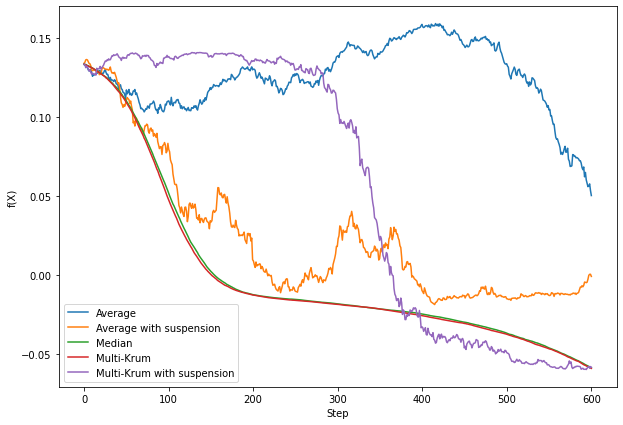

In [53]:
begin = 0

y_avg = [values_avg[i][1] for i in range(begin, len(values_avg))]
X_avg = np.linspace(begin, len(values_avg), len(values_avg)-begin)

y_avg_sus = [values_avg_sus[i][1] for i in range(begin, len(values_avg_sus))]
X_avg_sus = np.linspace(begin, len(values_avg_sus), len(values_avg_sus)-begin)

y_med = [values_med[i][1] for i in range(begin, len(values_med))]
X_med = np.linspace(begin, len(values_med), len(values_med)-begin)

y_krum = [values_krum[i][1] for i in range(begin, len(values_krum))]
X_krum = np.linspace(begin, len(values_krum), len(values_krum)-begin)

y_krum_sus = [values_krum_sus[i][1] for i in range(begin, len(values_krum_sus))]
X_krum_sus = np.linspace(begin, len(values_krum_sus), len(values_krum_sus)-begin)

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.plot(X_avg, y_avg, label='Average')
ax.plot(X_avg_sus, y_avg_sus, label='Average with suspension')
ax.plot(X_med, y_med, label='Median')
ax.plot(X_krum, y_krum, label='Multi-Krum')
ax.plot(X_krum_sus, y_krum_sus, label='Multi-Krum with suspension')
ax.set_xlabel('Step')
ax.set_ylabel('f(X)')
ax.legend()
plt.savefig('kgraph_{}_{}_1_{}_{}'.format(nbworkers, nbbyzwrks, nb_sus, sus_time), dpi=200)
plt.show()

On this particular experiment, suspension-based aggregators seem to performs better than classic ones, as they might be able to detect Byzantine agents. Below is plotted the trajectory on the function for each aggregator.

This promising but preliminary work opens the door for further investigation. We could sample on a great number of experiments, while changing the parameters (starting point, distribution of vectors returned by Byzantine workers, learning rate, suspension time, number of sorkers suspended at each step, etc.)


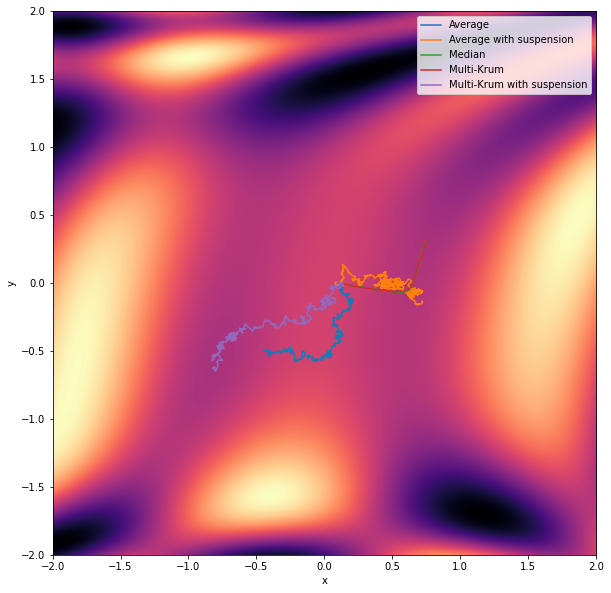

In [54]:
#plot the function and the X trajectory

hw = 2   #half width
x = np.linspace(-hw, hw, 300)
y = np.linspace(-hw, hw, 300)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])
z = f1(xy)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
im = ax.imshow(z, interpolation='bilinear', origin='lower', cmap='magma', extent=[-hw,hw,-hw,hw])

#average
x_avg = [values_avg[i][0][0] for i in range(len(values_avg))]
y_avg = [values_avg[i][0][1] for i in range(len(values_avg))]
ax.plot(x_avg, y_avg, label = 'Average')

#average with suspension
x_avg_sus = [values_avg_sus[i][0][0] for i in range(len(values_avg_sus))]
y_avg_sus = [values_avg_sus[i][0][1] for i in range(len(values_avg_sus))]
ax.plot(x_avg_sus, y_avg_sus, label = 'Average with suspension')

#median
x_med = [values_med[i][0][0] for i in range(len(values_med))]
y_med = [values_med[i][0][1] for i in range(len(values_med))]
ax.plot(x_med, y_med, label = 'Median')

#multi_krum
x_krum = [values_krum[i][0][0] for i in range(len(values_krum))]
y_krum = [values_krum[i][0][1] for i in range(len(values_krum))]
ax.plot(x_krum, y_krum, label = 'Multi-Krum')

#multi_krum with suspension
x_krum_sus = [values_krum_sus[i][0][0] for i in range(len(values_krum_sus))]
y_krum_sus = [values_krum_sus[i][0][1] for i in range(len(values_krum_sus))]
ax.plot(x_krum_sus, y_krum_sus, label='Multi-Krum with suspension')

ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.pcolor(x, y, z)
#plt.colorbar()
ax.legend()

plt.savefig('kmap_{}_{}_1_{}_{}'.format(nbworkers, nbbyzwrks, nb_sus, sus_time), dpi=200)
plt.show()

### Test (ignore this part)

In [1277]:

def test_update_workers_status(aggregator):
    '''Tests the update_workers_status method in the deterministic case.
    '''
    
    if aggregator.probability is not None:
        print('aggregator.probability should be None to run the test.')
        return
    else:
        aggregator.workers_status = [[True, 0], [False, 3], [True, 0], [False, 2], [False, 1], [False, 3]]
        aggregator.nb_suspended=2 
        aggregator.suspension_time=2

        sorted_workers_ids = [2,5,1,0,3,4]
        aggregator.update_workers_status(sorted_workers_ids)
        expected_output = [[True, 0], [False, 2], [True, 0], [False, 2], [False, 2], [False, 2]]
        output = aggregator.workers_status
        print('act_output: ', output)
        print('exp_output: ', expected_output)
        print(output==expected_output)


        sorted_workers_ids = [5,3,1,0,2,4]
        aggregator.update_workers_status(sorted_workers_ids)
        expected_output = [[True, 0], [False, 1], [False, 2], [False, 1], [False, 2], [False, 1]]
        output = aggregator.workers_status
        print('act_output: ', output)
        print('exp_output: ', expected_output)
        print(output==expected_output)

        sorted_workers_ids = [1,3,4,2,0,5]
        aggregator.update_workers_status(sorted_workers_ids)
        expected_output = [[False, 2], [True, 0], [False, 1], [True, 0], [False, 1], [False, 2]]
        output = aggregator.workers_status
        print('act_output: ', output)
        print('exp_output: ', expected_output)
        print(output==expected_output)

In [317]:
aggregator = Krum(5,2)
test_update_workers_status(aggregator)

act_output:  [[True, 0], [False, 2], [True, 0], [False, 2], [False, 2], [False, 2]]
exp_output:  [[True, 0], [False, 2], [True, 0], [False, 2], [False, 2], [False, 2]]
True
act_output:  [[True, 0], [False, 1], [False, 2], [False, 1], [False, 2], [False, 1]]
exp_output:  [[True, 0], [False, 1], [False, 2], [False, 1], [False, 2], [False, 1]]
True
act_output:  [[False, 2], [True, 0], [False, 1], [True, 0], [False, 1], [False, 2]]
exp_output:  [[False, 2], [True, 0], [False, 1], [True, 0], [False, 1], [False, 2]]
True
